In [ ]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
import scipy.misc
from PIL import Image
from scipy import ndimage
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import datasets, layers, models, optimizers, regularizers
from keras.preprocessing.image import img_to_array, array_to_img, load_img
from tensorflow.keras.applications.nasnet import NASNetMobile

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)]
    return Y

In [ ]:
def load_dataset():
    train_dataset = h5py.File('/content/drive/My Drive/Datasets/SIRI-WHU/Train_SIRI-WHU.h5', 'r')
    train_set_x_orig = np.array(train_dataset["X_train_dataset"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["Y_train_dataset"][:]) # your train set labels

    test_dataset = h5py.File('/content/drive/My Drive/Datasets/SIRI-WHU/Test_SIRI-WHU.h5', 'r')
    test_set_x_orig = np.array(test_dataset["X_test_dataset"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["Y_test_dataset"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [ ]:
# Loading the data (Dataset)
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

y = 1


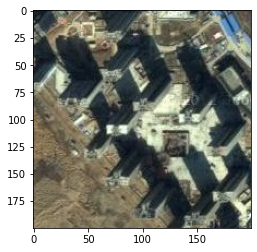

In [ ]:
#for i in range(X_train_orig.shape[0]):
#  X_train_orig[i] = Image.fromarray(X_train_orig[i].astype(np.uint8)).convert(mode='HSV')
#  X_train_orig[i] = Image.fromarray(X_train_orig[i].astype(np.uint8)).convert(mode='YCbCr')

#for j in range(X_test_orig.shape[0]):
#  X_test_orig[j] = Image.fromarray(X_test_orig[j].astype(np.uint8)).convert(mode='HSV')
#  X_test_orig[j] = Image.fromarray(X_test_orig[j].astype(np.uint8)).convert(mode='YCbCr')

index = 25
plt.imshow(Image.fromarray(X_train_orig[index].astype(np.uint8)))
print ("y = " + str(np.squeeze(Y_train_orig[:, index])))

In [ ]:
X_train = X_train_orig/255.
X_test = X_test_orig/255.
Y_train = convert_to_one_hot(Y_train_orig, 12)
Y_test = convert_to_one_hot(Y_test_orig, 12)

print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 1920
number of test examples = 480
X_train shape: (1920, 200, 200, 3)
Y_train shape: (1920, 12)
X_test shape: (480, 200, 200, 3)
Y_test shape: (480, 12)


In [ ]:
Nasnet_Out = h5py.File('/content/drive/My Drive/Datasets/SIRI-WHU/Convout/TLB1000/Nasnet_Out.h5', 'r')
Txtrain = np.array(Nasnet_Out["train_OutNasnet"][:])
Txtest = np.array(Nasnet_Out["test_OutNasnet"][:])
Nasnet_Out.close()

print("Txtrain Shape:", Txtrain.shape)
print("Txtest Shape:", Txtest.shape)

Txtrain Shape: (1920, 1056)
Txtest Shape: (480, 1056)


In [ ]:
model = models.Sequential()
model.add(layers.Input(shape = (1056)))
model.add(layers.ReLU())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(12, activation='softmax'))
print(model.summary())

#optimizers.SGD(learning_rate=0.0001, momentum=0.9, name="SGD", decay=1e-4)
optimizers.Adam(learning_rate=0.001, name="Adam")
model.compile(optimizer='Adam', loss = 'categorical_crossentropy', metrics=['accuracy'])

Vhistory = model.fit(Txtrain, Y_train, epochs=200, batch_size=64, validation_split = 0.25)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
re_lu (ReLU)                 (None, 1056)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1056)              0         
_________________________________________________________________
dense (Dense)                (None, 12)                12684     
Total params: 12,684
Trainable params: 12,684
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/200
23/23 [==============================] - 0s 11ms/step - loss: 2.3876 - accuracy: 0.2076 - val_loss: 1.6665 - val_accuracy: 0.5458
Epoch 2/200
23/23 [==============================] - 0s 4ms/step - loss: 1.5871 - accuracy: 0.4812 - val_loss: 1.2190 - val_accuracy: 0.6958
Epoch 3/200
23/23 [==============================] - 0s 5ms/step - loss: 1.1978 - accuracy: 0.

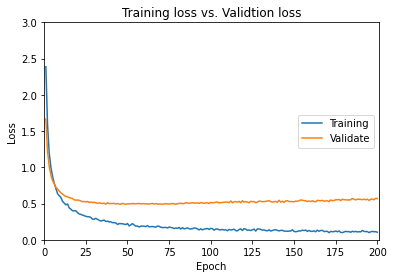

In [ ]:
epochs = len(Vhistory.history['loss'])
max_loss = max(max(Vhistory.history['loss']), max(Vhistory.history['val_loss']))
plt.axis([0, epochs+1, 0, round(max_loss * 2.0) / 2 + 0.5])
x = np.arange(1, epochs+1)
plt.plot(x, Vhistory.history['loss'])
plt.plot(x, Vhistory.history['val_loss'])
plt.title('Training loss vs. Validtion loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validate'], loc='right')
plt.show()

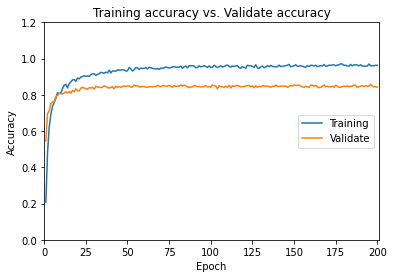

In [ ]:
epochs = len(Vhistory.history['accuracy'])
plt.axis([0, epochs+1, 0, 1.2])
x = np.arange(1, epochs+1)
plt.plot(x, Vhistory.history['accuracy'])
plt.plot(x, Vhistory.history['val_accuracy'])
plt.title('Training accuracy vs. Validate accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validate'], loc='right')
plt.show()

In [ ]:
epochs = np.argmin(Vhistory.history['val_loss']) + 1

history = model.fit(Txtrain, Y_train, epochs=epochs, verbose=1, batch_size=64)

train_loss, train_acc = model.evaluate(Txtrain,  Y_train, verbose=1)
print("Loss: ", train_loss, " Trin Accuracy: ", train_acc)

test_loss, test_acc = model.evaluate(Txtest,  Y_test, verbose=1)
print("Loss: ", test_loss, " Test Accuracy: ", test_acc)

Epoch 1/125
27/27 [==============================] - 0s 3ms/step - loss: 0.0093 - accuracy: 0.9982
Epoch 2/125
27/27 [==============================] - 0s 3ms/step - loss: 0.0157 - accuracy: 0.9946
Epoch 3/125
27/27 [==============================] - 0s 3ms/step - loss: 0.0102 - accuracy: 0.9976
Epoch 4/125
27/27 [==============================] - 0s 3ms/step - loss: 0.0144 - accuracy: 0.9952
Epoch 5/125
27/27 [==============================] - 0s 3ms/step - loss: 0.0197 - accuracy: 0.9929
Epoch 6/125
27/27 [==============================] - 0s 3ms/step - loss: 0.0106 - accuracy: 0.9976
Epoch 7/125
27/27 [==============================] - 0s 3ms/step - loss: 0.0139 - accuracy: 0.9958
Epoch 8/125
27/27 [==============================] - 0s 3ms/step - loss: 0.0106 - accuracy: 0.9970
Epoch 9/125
27/27 [==============================] - 0s 3ms/step - loss: 0.0137 - accuracy: 0.9964
Epoch 10/125
27/27 [==============================] - 0s 3ms/step - loss: 0.0126 - accuracy: 0.9958
Epoch 11/

In [ ]:
import pandas as pd

array1 = np.zeros((200,2))
array1[:,0] = Vhistory.history['loss']
array1[:,1] = Vhistory.history['val_loss']

array2 = np.zeros((200,2))
array2[:,0] = Vhistory.history['accuracy']
array2[:,1] = Vhistory.history['val_accuracy']

df1 = pd.DataFrame(array1)
df1.to_excel("/content/drive/My Drive/NASSL.xlsx", sheet_name='SIRI Loss')

df2 = pd.DataFrame(array2)
df2.to_excel("/content/drive/My Drive/NASSA.xlsx", sheet_name='SIRI accuracy')

